In [152]:
import pickle
import torch
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import sklearn.metrics   as metrics
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [153]:
splits = ['train', 'valid', 'none', 'test']
dataset = {}

for split in splits:
    with open(f'preprocessed/fake_news/embeddings/{split}.pkl', 'rb') as file:
        dataset[split] = pickle.load(file)

    with open(f'preprocessed/fake_news/targets/{split}.pkl', 'rb') as file:
        dataset[split]['y'] = pickle.load(file)

In [154]:
batch_size = 1024

train_loader = DataLoader(TensorDataset(*dataset['train'].values()), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(*dataset['valid'].values()), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(*dataset['test' ].values()), batch_size=batch_size, shuffle=False)

# Create dataset for training after hyper-parameter tunning, using both train, valid and none sets
all_X = torch.cat((dataset['train']['X'], dataset['valid']['X'], dataset['none']['X']))
all_y = torch.cat((dataset['train']['y'], dataset['valid']['y'], dataset['none']['y']))

all_loader = DataLoader(TensorDataset(all_X, all_y), batch_size=batch_size, shuffle=True)

In [155]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'

model = nn.Linear(768, 4)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
epochs = 150

model.to(device)

train_loss_history = []
valid_loss_history = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):

        model.train()

        train_loss = 0

        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)

            out = model(data)
            loss = criterion(out, target)
            train_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()

        train_loss_history += [train_loss]

        model.eval()

        valid_loss = 0

        y_pred = []
        y_true  = []

        with torch.no_grad():
            for data, target in valid_loader:
                y_true += [target.numpy()]

                data = data.to(device)
                target = target.to(device)

                out = model(data)
                loss = criterion(out, target)
                valid_loss += loss.item()
                y_pred += [torch.argmax(nn.Softmax(dim=1)(out), dim=1).cpu().numpy()]

        valid_loss_history += [valid_loss]

        y_pred = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)

        acc = metrics.accuracy_score(y_true, y_pred) * 100
        f1 = metrics.f1_score(y_true, y_pred, average='macro') * 100

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)

        print(f'Epoch: {epoch:2d} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f} | valid acc: {acc:.1f}% | f-1 valid: {f1:.1f}')

        pbar.update(1)

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch:  0 | train loss: 0.483 | valid loss: 0.337 | valid acc: 87.4% | f-1 valid: 46.3
Epoch:  1 | train loss: 0.291 | valid loss: 0.308 | valid acc: 88.2% | f-1 valid: 48.7
Epoch:  2 | train loss: 0.273 | valid loss: 0.297 | valid acc: 89.4% | f-1 valid: 55.2
Epoch:  3 | train loss: 0.260 | valid loss: 0.290 | valid acc: 89.5% | f-1 valid: 56.4
Epoch:  4 | train loss: 0.252 | valid loss: 0.284 | valid acc: 89.9% | f-1 valid: 57.4
Epoch:  5 | train loss: 0.245 | valid loss: 0.283 | valid acc: 90.0% | f-1 valid: 57.7
Epoch:  6 | train loss: 0.239 | valid loss: 0.278 | valid acc: 90.1% | f-1 valid: 58.2
Epoch:  7 | train loss: 0.234 | valid loss: 0.271 | valid acc: 90.0% | f-1 valid: 57.6
Epoch:  8 | train loss: 0.230 | valid loss: 0.269 | valid acc: 90.4% | f-1 valid: 58.6
Epoch:  9 | train loss: 0.227 | valid loss: 0.268 | valid acc: 90.2% | f-1 valid: 57.9
Epoch: 10 | train loss: 0.223 | valid loss: 0.265 | valid acc: 90.3% | f-1 valid: 58.6
Epoch: 11 | train loss: 0.220 | valid loss:

Min valid loss at epoch: 92


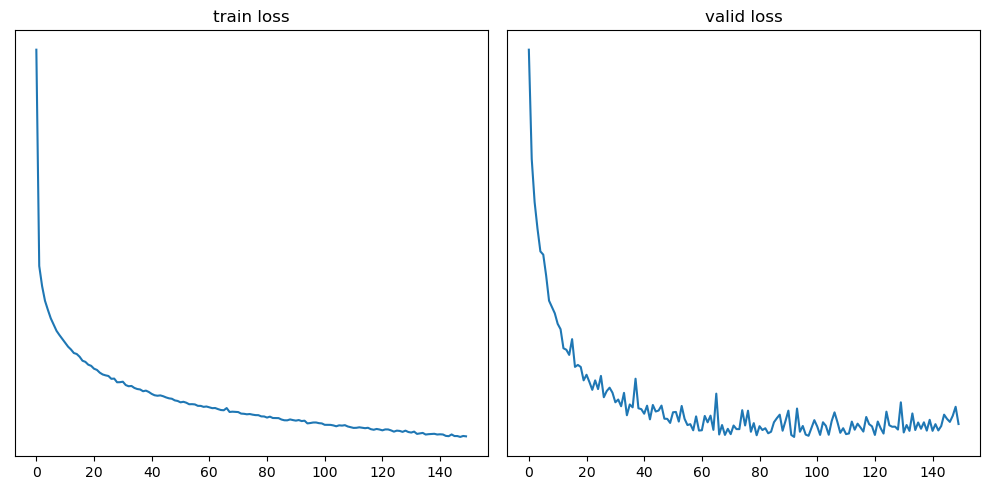

In [156]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x=np.arange(epochs), y=train_loss_history, ax=ax[0])
sns.lineplot(x=np.arange(epochs), y=valid_loss_history, ax=ax[1])

ax[0].set_title('train loss')
ax[1].set_title('valid loss')
ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
plt.tight_layout()

early_stopping = np.argmin(valid_loss_history)

print(f'Min valid loss at epoch: {early_stopping}')

In [157]:
# Retrain the model on train, valid & none set until an early stopping criterion
model = nn.Linear(768, 4)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

model.to(device)

with tqdm(total=early_stopping) as pbar:
    for epoch in range(early_stopping):
        for data, target in all_loader:
            data = data.to(device)
            target = target.to(device)

            out = model(data)
            loss = criterion(out, target)
            train_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()

        pbar.update(1)

# save model
torch.save(model, 'models/fake_news_classifier.pth')

  0%|          | 0/92 [00:00<?, ?it/s]

# Evaluation

In [158]:
y_true_train = []
y_pred_train = []
y_true_test  = []
y_pred_test  = []

model.eval()

with torch.no_grad():
    for data, target in all_loader:
        y_true_train += [target.numpy()]

        data = data.to(device)
        target = target.to(device)
        out = model(data)

        y_pred_train += [torch.argmax(nn.Softmax(dim=1)(out), dim=1).cpu().numpy()]

    for data, target in test_loader:
        y_true_test += [target.numpy()]

        data = data.to(device)
        target = target.to(device)
        out = model(data)

        y_pred_test += [torch.argmax(nn.Softmax(dim=1)(out), dim=1).cpu().numpy()]

    y_true_train = np.concatenate(y_true_train)
    y_pred_train = np.concatenate(y_pred_train)
    y_true_test  = np.concatenate(y_true_test)
    y_pred_test  = np.concatenate(y_pred_test)

**Dummy Baseline**
- always return unrelated

In [159]:
labels = ['unrelated', 'agree', 'disagree', 'discuss']
dummy_pred = [0] * len(y_true_test)

print(metrics.classification_report(y_true_test, dummy_pred, target_names=labels))

              precision    recall  f1-score   support

   unrelated       0.72      1.00      0.84     18023
       agree       0.00      0.00      0.00      1893
    disagree       0.00      0.00      0.00       697
     discuss       0.00      0.00      0.00      4430

    accuracy                           0.72     25043
   macro avg       0.18      0.25      0.21     25043
weighted avg       0.52      0.72      0.60     25043



C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcin\miniconda3\envs\sages\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   unrelated       0.99      0.99      0.99     36262
       agree       0.72      0.72      0.72      3643
    disagree       0.68      0.34      0.46       829
     discuss       0.85      0.89      0.87      8804

    accuracy                           0.94     49538
   macro avg       0.81      0.74      0.76     49538
weighted avg       0.94      0.94      0.94     49538



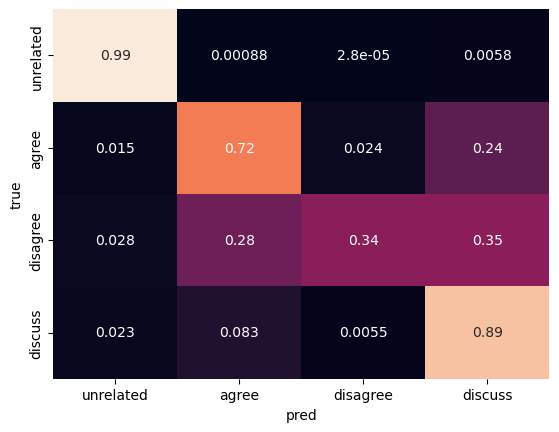

In [160]:
# Train set performance
print(metrics.classification_report(y_true_train, y_pred_train, target_names=labels))

ax = sns.heatmap(metrics.confusion_matrix(y_true_train, y_pred_train, normalize='true'), cbar=False, annot=True, xticklabels=labels, yticklabels=labels)

ax.set_xlabel('pred')
ax.set_ylabel('true');

              precision    recall  f1-score   support

   unrelated       0.98      0.98      0.98     18023
       agree       0.44      0.64      0.52      1893
    disagree       0.21      0.05      0.08       697
     discuss       0.75      0.70      0.72      4430

    accuracy                           0.88     25043
   macro avg       0.60      0.59      0.58     25043
weighted avg       0.88      0.88      0.88     25043



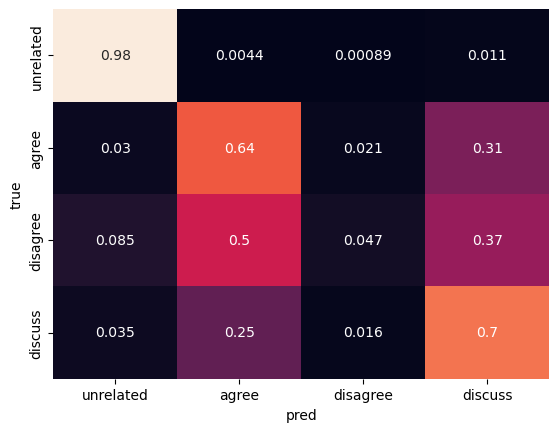

In [161]:
# Test set performance
print(metrics.classification_report(y_true_test, y_pred_test, target_names=labels))

ax = sns.heatmap(metrics.confusion_matrix(y_true_test, y_pred_test, normalize='true'), cbar=False, annot=True, xticklabels=labels, yticklabels=labels)

ax.set_xlabel('pred')
ax.set_ylabel('true');